In [ ]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.0 MB/s eta 0:00:00


In [ ]:
import torch
from matplotlib import pyplot as plt

# B1

## Generating data

In [ ]:
def g(x):
    """
    g(x) = - (sin(6*pi*x))^2 + 6*x^2 - 5*x^4 + 1.5
    """
    return -(torch.sin(6.0 * torch.pi * x))**2 + 6.0*x**2 - 5.0*x**4 + 1.5

def generate_data(device = 'cuda'):


    # Defining the grid x_i = (i-1)/(l-1) for i=1..l with l=30
    l = 30
    x = torch.linspace(0.0, 1.0, l, device = device)  # same as (i-1)/(l-1)

    # Computing y_i = g(x_i) + epsilon_i, where epsilon_i ~ N(0, 0.01)
    noise_std = torch.sqrt(torch.tensor(0.01, device = device))  # standard deviation = 0.1
    y_true = g(x)
    epsilon = torch.normal(0.0, noise_std, size = (l,), device = device)
    y = y_true + epsilon

    # Randomly splitting into 20 training points and 10 test points
    idx = torch.randperm(l, device = device)
    train_idx = idx[:20]
    test_idx  = idx[20:]

    x_train = x[train_idx]
    y_train = y[train_idx]
    x_test  = x[test_idx]
    y_test  = y[test_idx]

    return x_train, y_train, x_test, y_test


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x_train, y_train, x_test, y_test = generate_data(device = device)

y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean)/y_std
y_test = (y_test - y_mean)/y_std

Using device: cuda


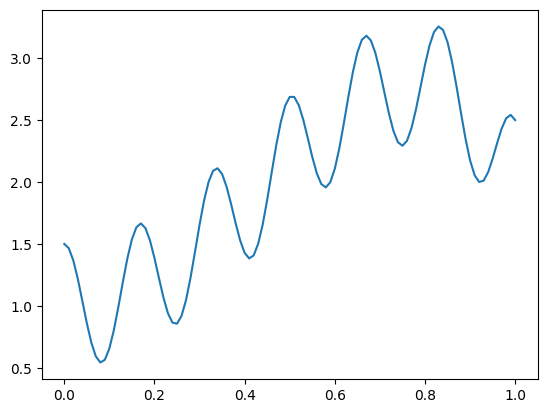

In [ ]:
plt.plot(torch.linspace(0,1,101), g(torch.linspace(0,1,101)))
plt.show()

## Defining kernel

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Defining kernels as Torch tensors, for Pyro

def rbf_kernel(x, xp, alpha, length):
    """
    RBF/Gaussian kernel (PyTorch, GPU-compatible).
    x, xp: 1D torch tensors on the same device.
    """
    x_col = x.unsqueeze(-1)     # shape (n, 1)
    xp_row = xp.unsqueeze(0)    # shape (1, m)
    sqdist = (x_col - xp_row)**2
    return alpha**2 * torch.exp(-0.5 * sqdist / (length**2))


def periodic_kernel(x, xp, alpha, length, period=1.0):
    """
    Periodic kernel (PyTorch, GPU-compatible).
    """
    x_col = x.unsqueeze(-1)
    xp_row = xp.unsqueeze(0)
    diff = x_col - xp_row
    sin_sq = torch.sin(torch.pi * diff / period)**2
    return alpha**2 * torch.exp(-2.0 * sin_sq / (length**2))


def summed_kernel(x, xp, alpha_rbf, length_rbf, alpha_per, length_per, period):
    """
    Sum of RBF and Periodic kernels (PyTorch, GPU-compatible).
    """
    K_rbf = rbf_kernel(x, xp, alpha_rbf, length_rbf)
    K_per = periodic_kernel(x, xp, alpha_per, length_per, period)
    return K_rbf + K_per


Using device: cuda


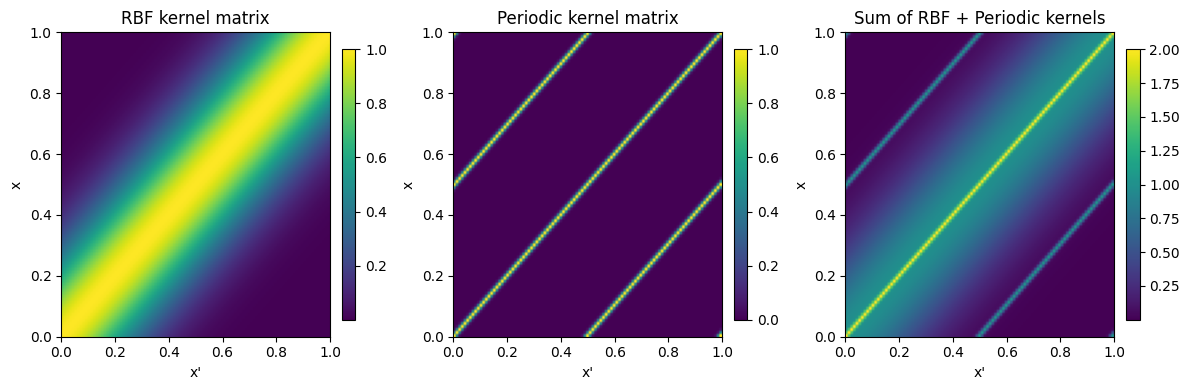

In [ ]:
""" Visualising the kernel matrices"""

# Creating a grid of x-values in [0, 1]
n_grid = 101
x_grid = torch.linspace(0., 1., n_grid, device = device)

# Example hyperparameters for plotting kernels
alpha_rbf = 1.0
length_rbf = 0.2

alpha_per = 1.0
length_per = 0.1
period = 0.5

params = torch.tensor([1.0, 0.5, 1.0, 0.2, 1/6], device='cuda')

# RBF kernel matrix
K_rbf = rbf_kernel(x_grid, x_grid, alpha_rbf, length_rbf)

# Periodic kernel matrix
K_per = periodic_kernel(x_grid, x_grid, alpha_per, length_per, period)

# Summed kernel matrix
K_sum = summed_kernel(x_grid, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period)

# Moving kernel matrices to CPU for visualization
K_rbf = K_rbf.cpu().numpy()
K_per = K_per.cpu().numpy()
K_sum = K_sum.cpu().numpy()

# Plot each kernel matrix side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# RBF
im0 = axs[0].imshow(K_rbf, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='viridis')
axs[0].set_title("RBF kernel matrix")
axs[0].set_xlabel("x'")
axs[0].set_ylabel("x")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Periodic
im1 = axs[1].imshow(K_per, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='viridis')
axs[1].set_title("Periodic kernel matrix")
axs[1].set_xlabel("x'")
axs[1].set_ylabel("x")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Summed
im2 = axs[2].imshow(K_sum, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='viridis')
axs[2].set_title("Sum of RBF + Periodic kernels")
axs[2].set_xlabel("x'")
axs[2].set_ylabel("x")
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Functions for -log_likelihood and optimizing params (based on lecture)

In [ ]:
# priors for params:
# all follow a LogNorm(mu, sigma), given by:
mus = torch.tensor([torch.log(torch.tensor(0.5)), torch.log(torch.tensor(1.0)), torch.log(torch.tensor(0.5)), torch.log(torch.tensor(1.0)), torch.log(torch.tensor(1.0))], device='cuda')
sigmas = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5], device='cuda')
params = torch.tensor([0.5, 1.0, 0.5, 1.0, 1.0], device='cuda')

def log_prior(params, mus, sigmas):
    """
    theta: array of shape (5,) -> [alpha_rbf, length_rbf, alpha_per, length_per, period]
    mus:   array of shape (5,) -> log-space means for each param
    sigmas:array of shape (5,) -> log-space std dev for each param

    Returns the sum of log-likelihoods under independent lognormal priors.
    """
    total_logp = torch.tensor(0.0, device = params.device)
    for p, mu, sigma in zip(params, mus, sigmas):
        # If the parameter is non-positive, the lognormal pdf is 0 => logpdf = -inf
        if p <= 0:
            return torch.tensor(float('-inf'), device = params.device)

        # log-normal from PyTorch
        lognorm = torch.distributions.LogNormal(loc = mu, scale = sigma)
        lp = lognorm.log_prob(p)
        total_logp += lp

    return total_logp

def negLogLikelihood(params, X = x_train, y = y_train, verbose = False):

    alpha_rbf, length_rbf, alpha_per, length_per, period = params

    noise_y = 0.01
    sigma_y_I = noise_y * torch.eye(y.shape[0], device=X.device)

    K = summed_kernel(X, X, alpha_rbf, length_rbf, alpha_per, length_per, period)

    K_inv = torch.linalg.inv(K + sigma_y_I)
    observed_fit = y.T @ K_inv @ y

    # Computing model complexity
    model_complexity = torch.logdet(K + sigma_y_I)

    # Computing the log-prior
    log_pr = log_prior(params, mus, sigmas)

    if verbose:
      print(f"data fit={np.round(observed_fit,2)}")
      print(f"model complexity={np.round(model_complexity,2)}")
      print(f"log-prior={np.round(log_pr, 2)}")

    # Combine terms to compute negative log-posterior
    ll = -0.5 * observed_fit - 0.5 * model_complexity - log_pr

    # small HACK to avoid -inf of problematic regions
    if torch.isinf(ll) or torch.isnan(ll):
        return torch.tensor(float('inf'), device = X.device) # NOTE: we optimize by minimization, hence large positive value should be discarded by opt routine
    return -ll # NEGATIVE loglikelihood

def optimize_params(ranges, x_train, y_train, Ngrid):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x_train = torch.tensor(x_train, dtype = torch.float32, device = device)
    y_train = torch.tensor(y_train, dtype = torch.float32, device = device)
    param_grid = torch.stack([torch.linspace(r[0], r[1], Ngrid, device = device) for r in ranges], dim = 1).reshape(-1, len(ranges))

    opt_params = None
    nll_min = float('inf')

    # Checking all parameter combinations in a loop
    for params in param_grid:
      nll = negLogLikelihood(params, x_train, y_train)
      if nll < nll_min:
        nll_min = nll
        opt_params = params

    opt_params = opt_params.cpu().numpy() # Moving results to CPU in the end
    print(f"optimized NLL={nll}")
    return opt_params

In [ ]:
# Function for conditioning on data (based on lecture)
def conditional(X, x_star, y, noise_var, kernel):
    # See eq. 66 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    sigma_I = noise_var * torch.eye(y.shape[0], device = X.device)

    # Cholesky decomposition for numerical stability
    L = torch.linalg.cholesky(kernel(X, X) + sigma_I)

    # Solving K @ alpha = y
    alpha = torch.cholesky_solve(y.unsqueeze(-1), L)

    mu_star = kernel(X, x_star).T @ alpha

    # Computing posterior covariance
    v = torch.cholesky_solve(kernel(X, x_star), L)
    sigma_star = kernel(x_star, x_star) - kernel(X, x_star).T @ v

    return mu_star.squeeze(-1), sigma_star # return mean and covariance matrix

In [ ]:
"""MAP"""
# Reflecting realistic amplitude, length scales, and periodicity
# Defining ranges based on priors, but wider
ranges = [(0.01, 3.0), (0.01, 3.0), (0.01, 3.0), (0.01, 3.0), (0.01, 3.0)]
Ngrid = 10

optimal_parameters = optimize_params(ranges, x_train, y_train, Ngrid)
print("optimal params:", optimal_parameters)

<ipython-input-7-e8bc23341f55>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype = torch.float32, device = device)
<ipython-input-7-e8bc23341f55>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype = torch.float32, device = device)
<ipython-input-7-e8bc23341f55>:38: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:

optimized NLL=185.4585418701172
optimal params: [0.3422222 0.3422222 0.3422222 0.3422222 0.3422222]


In [ ]:
optimal_parameters

array([0.3422222, 0.3422222, 0.3422222, 0.3422222, 0.3422222],
      dtype=float32)

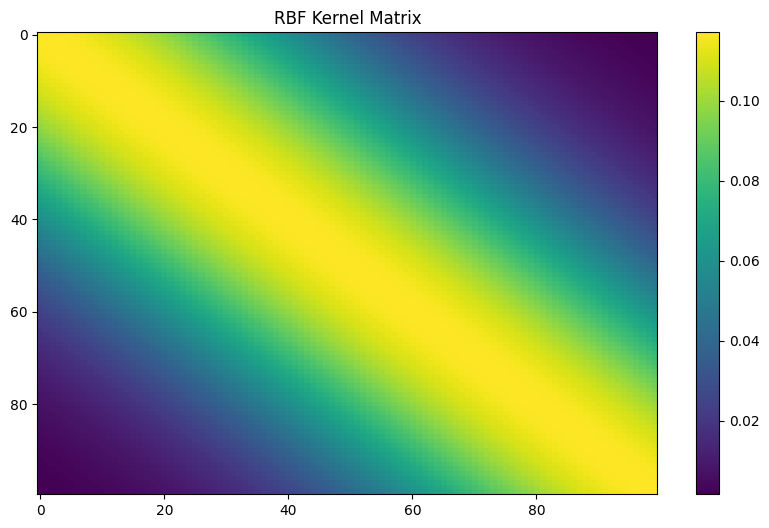

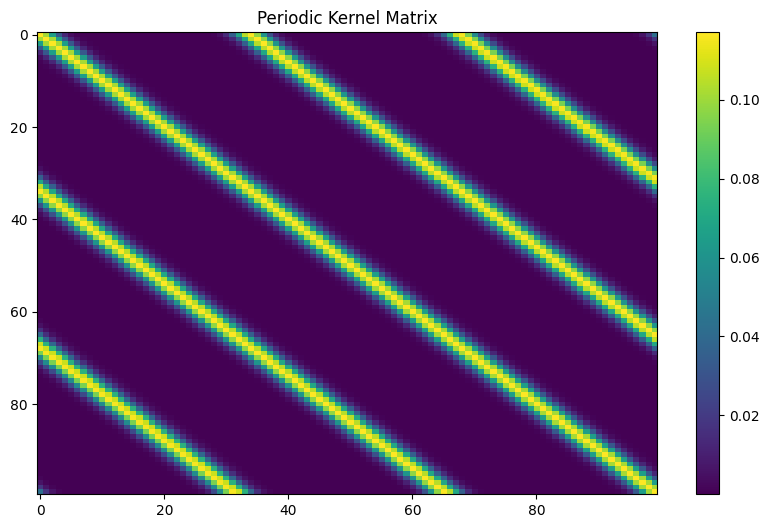

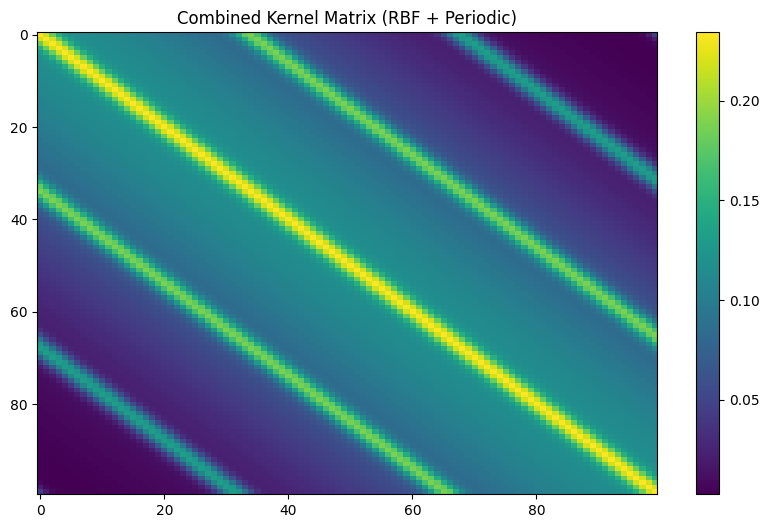

In [ ]:
""" Visualising kernels contribution"""

# Optimal hyperparameters
alpha_rbf, length_rbf = optimal_parameters[0], optimal_parameters[1]
alpha_per, length_per, period = optimal_parameters[2], optimal_parameters[3], optimal_parameters[4]

# Creating a grid of input points
x_grid = torch.linspace(0, 1, 100, device=device)  # 100 evenly spaced points

# Computing individual kernel matrices
K_rbf = rbf_kernel(x_grid, x_grid, alpha_rbf, length_rbf)
K_per = periodic_kernel(x_grid, x_grid, alpha_per, length_per, period)
K_combined = K_rbf + K_per

# Moving kernel matrices to CPU and convert to NumPy for visualization
K_rbf_np = K_rbf.cpu().numpy()
K_per_np = K_per.cpu().numpy()
K_combined_np = (K_rbf + K_per).cpu().numpy()

# Visualize RBF Kernel Contribution
plt.figure(figsize=(10, 6))
plt.imshow(K_rbf_np, aspect='auto', cmap='viridis')
plt.title("RBF Kernel Matrix")
plt.colorbar()
plt.show()

# Visualize Periodic Kernel Contribution
plt.figure(figsize=(10, 6))
plt.imshow(K_per_np, aspect='auto', cmap='viridis')
plt.title("Periodic Kernel Matrix")
plt.colorbar()
plt.show()

# Visualize Combined Kernel Contribution
plt.figure(figsize=(10, 6))
plt.imshow(K_combined_np, aspect='auto', cmap='viridis')
plt.title("Combined Kernel Matrix (RBF + Periodic)")
plt.colorbar()
plt.show()

## NUTS

In [ ]:
import arviz as az

In [ ]:
#!pip install pyro-ppl

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Pyro model definition
def gp_model(x_train, y_train, noise_std=0.1):

    # Ensure x_train, y_train are Tensors on the correct device
    x_train = torch.as_tensor(x_train, dtype=torch.float32, device=device)
    y_train = torch.as_tensor(y_train, dtype=torch.float32, device=device)

    # Sample hyperparameters as torch Tensors
    alpha_rbf  = pyro.sample("alpha_rbf",  dist.LogNormal(0.5, 0.5))
    length_rbf = pyro.sample("length_rbf", dist.LogNormal(1, 0.5))
    alpha_per  = pyro.sample("alpha_per",  dist.LogNormal(0.5, 0.5))
    length_per = pyro.sample("length_per", dist.LogNormal(1, 0.5))
    period     = pyro.sample("period_rbf", dist.LogNormal(1, 0.5))

    # Build covariance K on GPU using previously defined kernels
    K = summed_kernel(x_train, x_train, alpha_rbf, length_rbf, alpha_per, length_per, period=period)
    # Add noise to diagonal
    K_noise = K + noise_std**2 * torch.eye(len(x_train), device=device)

    # Zero mean
    mean = torch.zeros_like(x_train)

    # Observe data
    pyro.sample("obs", dist.MultivariateNormal(mean, covariance_matrix=K_noise), obs=y_train)

def run_mcmc(x_train, y_train, noise_std=0.1, num_samples=1000, warmup_steps=500):
    """
    Run MCMC using NUTS on the Gaussian Process model.
    """
    pyro.clear_param_store()
    nuts_kernel = NUTS(gp_model, step_size=0.01, adapt_step_size=True)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=1)
    mcmc.run(x_train, y_train, noise_std=noise_std)
    return mcmc

# Run MCMC
mcmc = run_mcmc(x_train, y_train, noise_std=0.1, num_samples=500,warmup_steps=200)

# Retrieve samples
samples = mcmc.get_samples()
for name, val in samples.items():
    print(name, val.shape, val.mean(dim=0))

Using device: cuda


Warmup:   9%|▉         | 66/700 [00:38,  3.05it/s, step size=2.41e-02, acc. prob=0.795]

KeyboardInterrupt: 

In [ ]:
print(optimal_parameters)

In [ ]:
import arviz as az
idata = az.from_pyro(mcmc)
az.plot_trace(idata)

In [ ]:
def gp_post_pred(x_train, y_train, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period, noise_std=0.1):

    x_train = torch.as_tensor(x_train, dtype=torch.float32, device="cpu")
    y_train = torch.as_tensor(y_train, dtype=torch.float32, device="cpu")
    x_grid = torch.as_tensor(x_grid, dtype=torch.float32, device="cpu")

    K_train = summed_kernel(x_train, x_train, alpha_rbf, length_rbf, alpha_per, length_per, period)
    K_train_noise = (K_train + noise_std**2 * torch.eye(len(x_train))).numpy()

    K_cross = summed_kernel(x_train, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period).numpy()  # (n_train x n_test)
    K_test_test = summed_kernel(x_grid, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period).numpy()  # (n_test x n_test)

    L = np.linalg.cholesky(K_train_noise)
    # Solve L * L^T * alpha = y_train
    alpha = np.linalg.solve(L, y_train)
    alpha = np.linalg.solve(L.T, alpha)  # => alpha = inv(K_train_noise) * y_train

    mean_test = K_cross.T @ alpha  # shape (n_test,)


    v = np.linalg.solve(L, K_cross)
    v = np.linalg.solve(L.T, v)  # => v = inv(K_train_noise) * K_cross
    cov_test = K_test_test - K_cross.T @ v

    return mean_test, cov_test

In [ ]:
def plot_gp_functions(x_train, y_train, x_grid, mean_test, cov_test, x_test = None, y_test = None, n_samples=3):

    x_train = x_train.cpu().numpy() if isinstance(x_train, torch.Tensor) else x_train
    y_train = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
    x_grid = x_grid.cpu().numpy() if isinstance(x_grid, torch.Tensor) else x_grid
    mean_test = mean_test.cpu().numpy() if isinstance(mean_test, torch.Tensor) else mean_test
    cov_test = cov_test.cpu().numpy() if isinstance(cov_test, torch.Tensor) else cov_test

    if x_test is not None:
        x_test = x_test.cpu().numpy() if isinstance(x_test, torch.Tensor) else x_test
    if y_test is not None:
        y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

    # Plotting training data
    plt.figure(figsize=(15, 5))
    plt.scatter(x_train, y_train, color='k', alpha=0.8, label="Train data")

    # Plotting predictive mean
    plt.plot(x_grid, mean_test, color='blue', label="Predictive mean")

    # Plotting confidence intervals
    std_test = np.sqrt(np.diag(cov_test))
    plt.fill_between(x_grid, mean_test - 1.96 * std_test, mean_test + 1.96 * std_test,
                     color='blue', alpha=0.2, label="95% Confidence Interval")

    # Plotting posterior samples
    samples = np.random.multivariate_normal(mean_test, cov_test + 1e-6 * np.eye(len(cov_test)), size=n_samples)
    for i, sample in enumerate(samples):
        plt.plot(x_grid, sample, alpha=0.6, label=f"Sample {i + 1}")

    # Plotting test datapoints
    if x_test is not None and y_test is not None:
      plt.scatter(x_test, y_test, color = 'red', marker = 'x', label = 'Test data')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Gaussian Process Predictions")
    plt.show()

In [ ]:
samples = mcmc.get_samples()
for name, val in samples.items():
    print(name, val.shape, val.mean(dim=0))

In [ ]:
list(samples.values())[0].mean()

In [ ]:

K_combined
K_combined_np

In [ ]:
from scipy.stats import multivariate_normal
def compute_posterior_likelihood(x_train, y_train, x_test, y_test, samples, noise_std=0.1):
    """
    Compute the approximate posterior likelihood using MCMC samples.
    """
    posterior_likelihoods = []

    for i in range(500):  # Use the first 500 samples
        alpha_rbf = samples["alpha_rbf"][i].cpu().item()
        length_rbf = samples["length_rbf"][i].cpu().item()
        alpha_per = samples["alpha_per"][i].cpu().item()
        length_per = samples["length_per"][i].cpu().item()
        period = samples["period_rbf"][i].cpu().item()

        # Compute posterior mean and covariance for test set
        mean_test, cov_test = gp_post_pred(
            x_train, y_train, x_test,
            alpha_rbf, length_rbf, alpha_per, length_per, period, noise_std
        )

        # Compute log-likelihood of test set
        try:
            likelihood = multivariate_normal.logpdf(
                y_test.cpu().numpy(),
                mean=mean_test,
                cov=cov_test + noise_std**2 * np.eye(len(cov_test))
            )
            posterior_likelihoods.append(likelihood)
        except np.linalg.LinAlgError:
            print(f"Numerical issue in sample {i}, skipping.")
            continue

    # Compute the mean posterior log-likelihood
    approx_posterior_likelihood = np.mean(posterior_likelihoods)
    return approx_posterior_likelihood

# Compute posterior likelihood for the test set
approx_posterior_likelihood = compute_posterior_likelihood(
    x_train, y_train, x_test, y_test, samples, noise_std=0.1
)
print(f"Approximate Posterior Test Set Log-Likelihood: {approx_posterior_likelihood}")

In [ ]:

x_grid = torch.linspace(0, 1, 1001).to(device)
alpha_rbf, length_rbf = list(samples.values())[1].mean(dim=0).item(), list(samples.values())[4].mean(dim=0).item()
alpha_per, length_per, period = list(samples.values())[0].mean(dim=0).item(), list(samples.values())[2].mean(dim=0).item(), list(samples.values())[4].mean(dim=0).item()
noise_std = 0.1

map_alpha_rbf, map_length_rbf = optimal_parameters[0], optimal_parameters[1]
map_alpha_per, map_length_per, map_period = optimal_parameters[2], optimal_parameters[3], optimal_parameters[4]

# Compute predictions
mean_test, cov_test = gp_post_pred(x_train, y_train, x_grid, alpha_rbf, length_rbf, alpha_per, length_per, period, noise_std)
print(alpha_rbf, length_rbf, alpha_per, length_per, period)

# Plotting results for MCMC
plot_gp_functions(x_train, y_train, x_grid, mean_test, cov_test, x_test = x_test, y_test = y_test, n_samples=3)

# MAP predictions
map_mean_test, map_cov_test = gp_post_pred(x_train, y_train, x_grid, map_alpha_rbf, map_length_rbf, map_alpha_per, map_length_per, map_period, noise_std)

# Plotting results for MAP
plot_gp_functions(x_train, y_train, x_grid, map_mean_test, map_cov_test, x_test = x_test, y_test = y_test, n_samples=3)

In [ ]:
# Compute MAP predictions specifically for x_test
map_mean_test, map_cov_test = gp_post_pred(
    x_train, y_train, x_test,
    map_alpha_rbf, map_length_rbf,
    map_alpha_per, map_length_per, map_period,
    noise_std
)
# Compute posterior log-likelihood for test set
from scipy.stats import multivariate_normal

map_log_likelihood = multivariate_normal.logpdf(
    y_test.cpu().numpy(),
    mean=map_mean_test,
    cov=map_cov_test + noise_std**2 * np.eye(len(map_cov_test))
)

print(f"MAP Test Set Log-Likelihood: {map_log_likelihood}")

#

In [ ]:
print(f"MAP Test Set Log-Likelihood: {map_log_likelihood}")
print(f"MCMC Approximate Posterior Test Set Log-Likelihood: {approx_posterior_likelihood}")

if approx_posterior_likelihood > map_log_likelihood:
    print("MCMC captures the posterior uncertainty better than MAP.")
else:
    print("MAP performs better or is comparable to MCMC.")

### Notes on why Log-Likelihood is better for MAP if MCMC resembles the true function g(x) more:

MAP optimization is highly sensitive to the priors on the hyperparameters. If the priors are biased towards overconfident or narrow periodic patterns, the MAP solution may result in higher likelihood but fail to generalize.

Solution:
- 	Analyze the prior’s impact on the MAP estimate. For example:
- Adjust the priors for the periodic kernel to reduce its dominance.
- Consider a prior for the length-scale (\ell) that allows more smoothness.

# B2

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

Using device: cuda


<ipython-input-17-8bc7d7565b7b>:166: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean=mean_np, cov=cov_np, size=num_samples)


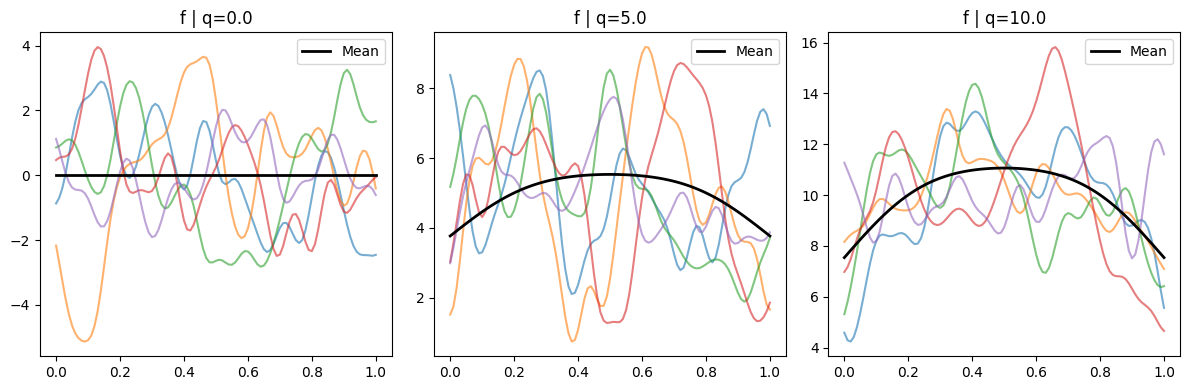

<ipython-input-17-8bc7d7565b7b>:336: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_np, cov_np, size=num_samples)


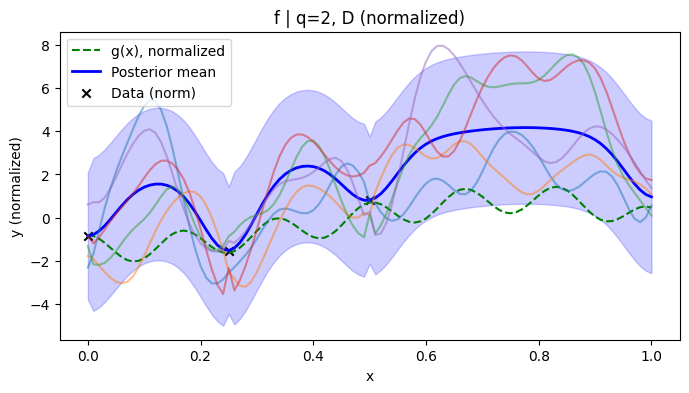

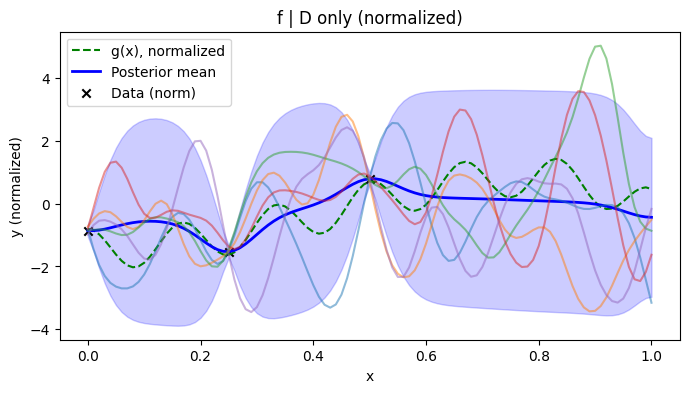

Done!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def g(x):
    """
    g(x) = -(sin(6*pi*x))^2 + 6*x^2 - 5*x^4 + 1.5
    """
    return -(torch.sin(6.0 * torch.pi * x))**2 + 6.0*x**2 - 5.0*x**4 + 1.5

def generate_data(device="cpu"):

    torch.manual_seed(0)  # for reproducibility

    # Defining the grid x_i = (i-1)/(l-1) for i=1..l with l=30
    l = 30
    x = torch.linspace(0.0, 1.0, l, device=device)

    # Compute y_i
    noise_std = torch.sqrt(torch.tensor(0.01, device=device))  # stdev = 0.1
    y_true = g(x)
    epsilon = torch.normal(0.0, noise_std, size=(l,), device=device)
    y = y_true + epsilon

    # Random split
    idx = torch.randperm(l, device=device)
    train_idx = idx[:20]
    test_idx  = idx[20:]

    x_train = x[train_idx]
    y_train = y[train_idx]
    x_test  = x[test_idx]
    y_test  = y[test_idx]

    return x_train, y_train, x_test, y_test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x_train, y_train, x_test, y_test = generate_data(device=device)

# Normalize y's (IMPORTANT for consistency with B.1)
y_mean = y_train.mean()
y_std  = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm  = (y_test  - y_mean) / y_std



def rbf_kernel(x, xp, alpha, length):

    x_col = x.unsqueeze(-1)
    xp_row = xp.unsqueeze(0)
    sqdist = (x_col - xp_row) ** 2
    return alpha**2 * torch.exp(-0.5 * sqdist / (length**2))

def periodic_kernel(x, xp, alpha, length, period=1.0):

    x_col = x.unsqueeze(-1)
    xp_row = xp.unsqueeze(0)
    diff = x_col - xp_row
    sin_sq = torch.sin(torch.pi * diff / period)**2
    return alpha**2 * torch.exp(-2.0 * sin_sq / (length**2))

def summed_kernel(x, xp, alpha_rbf, length_rbf, alpha_per, length_per, period):

    K_rbf = rbf_kernel(x, xp, alpha_rbf, length_rbf)
    K_per = periodic_kernel(x, xp, alpha_per, length_per, period)
    return K_rbf + K_per



optimal_parameters = [1.0, 0.2, 1.5, 0.3, 1.0]
# e.g.: alpha_rbf=1.0, length_rbf=0.2, alpha_per=1.5, length_per=0.3, period=1.0

map_alpha_rbf, map_length_rbf, map_alpha_per, map_length_per, map_period = optimal_parameters



def build_trap_weights(l):

    w = torch.full((l,), 1.0/(l-1))
    w[0]  = 1.0/(2*(l-1))
    w[-1] = 1.0/(2*(l-1))
    return w

# For demonstration, let's pick l_fine=101
l_fine = 101
x_fine = torch.linspace(0, 1, l_fine, device=device)
w_fine = build_trap_weights(l_fine).to(device)  # shape (101,)

K_fine = summed_kernel(
    x_fine, x_fine,
    torch.tensor(map_alpha_rbf, device=device),
    torch.tensor(map_length_rbf, device=device),
    torch.tensor(map_alpha_per, device=device),
    torch.tensor(map_length_per, device=device),
    torch.tensor(map_period,    device=device)
)



def f_given_q(K, w, q_value):

    w_col = w.view(-1, 1)            # shape (l, 1)
    Kw    = K @ w_col                # shape (l, 1)
    wKw   = (w_col.t() @ Kw).squeeze()  # scalar

    mean_fq = Kw * (q_value / wKw)   # shape (l,1)
    cov_fq  = K - (Kw @ Kw.t()) / wKw

    return mean_fq.squeeze(), cov_fq


def plot_samples_f_given_q(x_fine, w_fine, K_fine, q_values, num_samples=5):
    x_fine_np = x_fine.cpu().numpy()

    plt.figure(figsize=(12, 4))
    for idx, q_val in enumerate(q_values, start=1):
        mean_fq, cov_fq = f_given_q(K_fine, w_fine, q_val)
        mean_np = mean_fq.cpu().numpy()
        cov_np  = cov_fq.cpu().numpy()

        cov_np += 1e-10 * np.eye(cov_np.shape[0])

        # Sample
        samples = np.random.multivariate_normal(mean=mean_np, cov=cov_np, size=num_samples)

        plt.subplot(1, len(q_values), idx)
        for s in samples:
            plt.plot(x_fine_np, s, alpha=0.6)
        plt.plot(x_fine_np, mean_np, color='black', lw=2, label='Mean')
        plt.title(f"f | q={q_val}")
        plt.legend()
    plt.tight_layout()
    plt.show()

q_values_to_plot = [0.0, 5.0, 10.0]
plot_samples_f_given_q(x_fine, w_fine, K_fine, q_values_to_plot, num_samples=5)


D = [(0.0, 1.46), (0.25, 0.93), (0.5, 2.76)]
xD = torch.tensor([pt[0] for pt in D], dtype=torch.float32, device=device)
yD = torch.tensor([pt[1] for pt in D], dtype=torch.float32, device=device)

yD_norm = (yD - y_mean) / y_std

noise_std_data = 0.1  # stdev for the data => var=0.01

def f_given_q_and_data(x_fine, K_fine, w_fine, xD, yD_norm, q_value, noise_std_data=0.1):


    l_fine = K_fine.shape[0]
    nD = len(yD_norm)

    x_fine_np = x_fine.cpu().numpy()
    xD_np     = xD.cpu().numpy()

    data_indices = []
    for xd_val in xD_np:
        idx = np.argmin(np.abs(x_fine_np - xd_val))
        data_indices.append(idx)
    data_indices = torch.tensor(data_indices, device=device, dtype=torch.long)

    z = torch.zeros((1 + nD,), dtype=K_fine.dtype, device=device)
    z[0] = q_value
    z[1:] = yD_norm

    A = torch.zeros((1 + nD, l_fine), dtype=K_fine.dtype, device=device)
    A[0, :] = w_fine
    for i, idx in enumerate(data_indices):
        A[1 + i, idx] = 1.0

    Sig_z = A @ K_fine @ A.t()
    for i in range(nD):
        Sig_z[1 + i, 1 + i] += noise_std_data**2  # add data noise


    L = torch.linalg.cholesky(Sig_z)           # shape (1+nD, 1+nD)
    alpha = torch.cholesky_solve(z.view(-1,1), L)  # shape (1+nD,1)

    mu_f = K_fine @ A.t() @ alpha  # shape (l_fine,1)

    M = torch.cholesky_solve(A, L)  # shape (1+nD, l_fine)

    cov_f = K_fine - (K_fine @ A.t()) @ M
    return mu_f.squeeze(), cov_f



q0 = 2.0
mu_f_qD, cov_f_qD = f_given_q_and_data(
    x_fine, K_fine, w_fine,
    xD, yD_norm,
    q_value=q0,
    noise_std_data=noise_std_data
)

def f_given_data_only(x_fine, K_fine, xD, yD_norm, noise_std_data=0.1):
    """
    Standard GP posterior for data only (no integral constraint).
    """
    x_fine_np = x_fine.cpu().numpy()
    xD_np     = xD.cpu().numpy()
    data_indices = []
    for xd_val in xD_np:
        idx = np.argmin(np.abs(x_fine_np - xd_val))
        data_indices.append(idx)
    data_indices = torch.tensor(data_indices, device=device, dtype=torch.long)

    K_DD = K_fine[data_indices[:,None], data_indices[None,:]]
    K_XD = K_fine[:, data_indices]
    nD = len(yD_norm)

    Sig_D = K_DD + noise_std_data**2 * torch.eye(nD, device=device)
    L = torch.linalg.cholesky(Sig_D)
    alpha = torch.cholesky_solve(yD_norm.view(-1,1), L)  # shape(nD,1)

    mu_f = K_XD @ alpha  # shape(l_fine,1)

    M = torch.cholesky_solve(K_XD.t(), L)  # shape(nD,l_fine)
    cov_f = K_fine - K_XD @ M
    return mu_f.squeeze(), cov_f

mu_f_D, cov_f_D = f_given_data_only(
    x_fine, K_fine,
    xD, yD_norm,
    noise_std_data=noise_std_data
)



def plot_posterior(
    x_fine, mu_f, cov_f,
    xD, yD,
    title="Posterior (normalized)",
    num_samples=3
):
    x_fine_np = x_fine.cpu().numpy()
    mu_np = mu_f.detach().cpu().numpy()
    cov_np = cov_f.detach().cpu().numpy()

    cov_np += 1e-10 * np.eye(len(cov_np))

    std_diag = np.sqrt(np.diag(cov_np))
    lower_95 = mu_np - 1.95 * std_diag
    upper_95 = mu_np + 1.95 * std_diag

    plt.figure(figsize=(8, 4))

    # Plot the true function g(x) in normalized scale
    gx = g(x_fine)
    gx_norm = (gx - y_mean) / y_std
    plt.plot(x_fine_np, gx_norm.cpu().numpy(), 'g--', label="g(x), normalized")

    # Posterior mean
    plt.plot(x_fine_np, mu_np, 'b-', lw=2, label="Posterior mean")

    # 95% band
    plt.fill_between(x_fine_np, lower_95, upper_95, color='blue', alpha=0.2)

    # Data points (normalized)
    xD_np = xD.cpu().numpy()
    yD_np = yD.cpu().numpy()
    plt.scatter(xD_np, yD_np, color='k', marker='x', label="Data (norm)")

    # Random samples
    samples = np.random.multivariate_normal(mu_np, cov_np, size=num_samples)
    for i in range(num_samples):
        plt.plot(x_fine_np, samples[i], alpha=0.5)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y (normalized)")
    plt.legend()
    plt.show()

# f | q=2, D
plot_posterior(
    x_fine, mu_f_qD, cov_f_qD,
    xD, yD_norm,
    title="f | q=2, D (normalized)",
    num_samples=5
)

# f | D only
plot_posterior(
    x_fine, mu_f_D, cov_f_D,
    xD, yD_norm,
    title="f | D only (normalized)",
    num_samples=5
)

print("Done!")

Using device: cuda


<ipython-input-18-721840206a31>:173: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean=mean_np, cov=cov_np, size=num_samples)


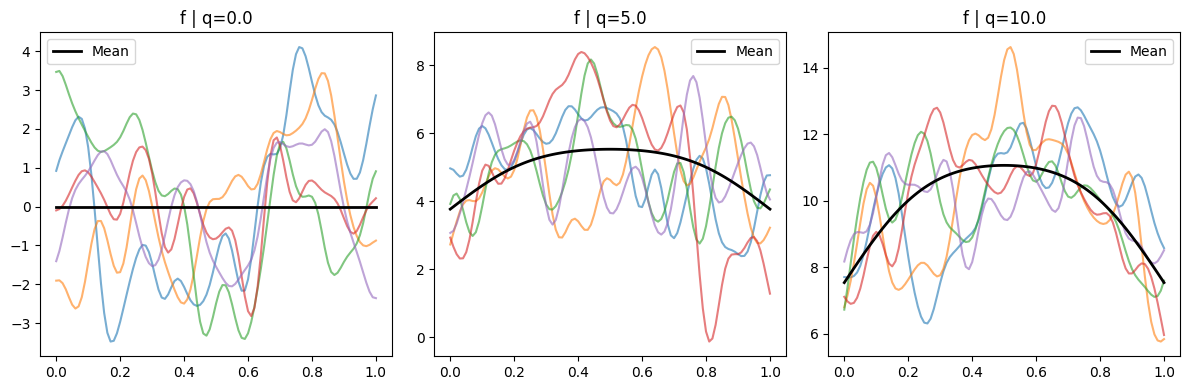

<ipython-input-18-721840206a31>:340: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu_np, cov_np, size=num_samples)


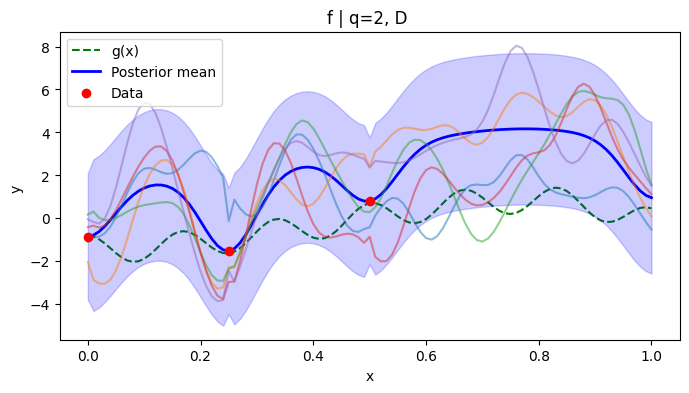

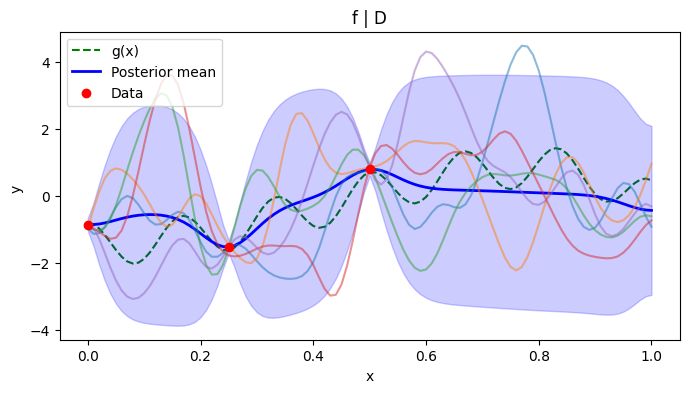

Done!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt



def g(x):
    """
    g(x) = -(sin(6*pi*x))^2 + 6*x^2 - 5*x^4 + 1.5
    """
    return -(torch.sin(6.0 * torch.pi * x))**2 + 6.0*x**2 - 5.0*x**4 + 1.5

def generate_data(device="cpu"):

    torch.manual_seed(0)  # for reproducibility

    # Defining the grid x_i = (i-1)/(l-1) for i=1..l with l=30
    l = 30
    x = torch.linspace(0.0, 1.0, l, device=device)

    # Compute y_i
    noise_std = torch.sqrt(torch.tensor(0.01, device=device))  # stdev = 0.1
    y_true = g(x)
    epsilon = torch.normal(0.0, noise_std, size=(l,), device=device)
    y = y_true + epsilon

    # Random split
    idx = torch.randperm(l, device=device)
    train_idx = idx[:20]
    test_idx  = idx[20:]

    x_train = x[train_idx]
    y_train = y[train_idx]
    x_test  = x[test_idx]
    y_test  = y[test_idx]

    return x_train, y_train, x_test, y_test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

x_train, y_train, x_test, y_test = generate_data(device=device)

y_mean = y_train.mean()
y_std  = y_train.std()
y_train_norm = (y_train - y_mean) / y_std
y_test_norm  = (y_test  - y_mean) / y_std



def rbf_kernel(x, xp, alpha, length):
    x_col = x.unsqueeze(-1)
    xp_row = xp.unsqueeze(0)
    sqdist = (x_col - xp_row) ** 2
    return alpha**2 * torch.exp(-0.5 * sqdist / (length**2))

def periodic_kernel(x, xp, alpha, length, period=1.0):
    x_col = x.unsqueeze(-1)
    xp_row = xp.unsqueeze(0)
    diff = x_col - xp_row
    sin_sq = torch.sin(torch.pi * diff / period)**2
    return alpha**2 * torch.exp(-2.0 * sin_sq / (length**2))

def summed_kernel(x, xp, alpha_rbf, length_rbf, alpha_per, length_per, period):
    K_rbf = rbf_kernel(x, xp, alpha_rbf, length_rbf)
    K_per = periodic_kernel(x, xp, alpha_per, length_per, period)
    return K_rbf + K_per

# Suppose we have "optimal_parameters" from B.1 on normalized data:
optimal_parameters = [1.0, 0.2, 1.5, 0.3, 1.0]
map_alpha_rbf, map_length_rbf, map_alpha_per, map_length_per, map_period = optimal_parameters

def build_trap_weights(l):

    w = torch.full((l,), 1.0/(l-1))
    w[0]  = 1.0/(2*(l-1))
    w[-1] = 1.0/(2*(l-1))
    return w

l_fine = 101
x_fine = torch.linspace(0, 1, l_fine, device=device)
w_fine = build_trap_weights(l_fine).to(device)  # shape (101,)

K_fine = summed_kernel(
    x_fine, x_fine,
    torch.tensor(map_alpha_rbf, device=device),
    torch.tensor(map_length_rbf, device=device),
    torch.tensor(map_alpha_per, device=device),
    torch.tensor(map_length_per, device=device),
    torch.tensor(map_period,    device=device)
)




def f_given_q(K, w, q_value):

    w_col = w.view(-1, 1)            # shape (l,1)
    Kw    = K @ w_col                # shape (l,1)
    wKw   = (w_col.t() @ Kw).squeeze()  # scalar

    mean_fq = Kw * (q_value / wKw)   # shape (l,1)
    cov_fq  = K - (Kw @ Kw.t()) / wKw

    return mean_fq.squeeze(), cov_fq


def plot_samples_f_given_q(x_fine, w_fine, K_fine, q_values, num_samples=5):
    x_fine_np = x_fine.cpu().numpy()

    plt.figure(figsize=(12, 4))
    for idx, q_val in enumerate(q_values, start=1):
        mean_fq, cov_fq = f_given_q(K_fine, w_fine, q_val)
        mean_np = mean_fq.cpu().numpy()
        cov_np  = cov_fq.cpu().numpy()

        cov_np += 1e-10 * np.eye(len(cov_np))

        samples = np.random.multivariate_normal(mean=mean_np, cov=cov_np, size=num_samples)

        plt.subplot(1, len(q_values), idx)
        for s in samples:
            plt.plot(x_fine_np, s, alpha=0.6)
        plt.plot(x_fine_np, mean_np, color='black', lw=2, label='Mean')
        plt.title(f"f | q={q_val}")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Execute the sample plotting for q in {0, 5, 10}
plot_samples_f_given_q(x_fine, w_fine, K_fine, q_values=[0.0, 5.0, 10.0], num_samples=5)



# The dataset:
D = [(0.0, 1.46), (0.25, 0.93), (0.5, 2.76)]
xD = torch.tensor([pt[0] for pt in D], dtype=torch.float32, device=device)
yD = torch.tensor([pt[1] for pt in D], dtype=torch.float32, device=device)

# Normalize based on the same y_mean, y_std
yD_norm = (yD - y_mean) / y_std

noise_std_data = 0.1  # stdev for the data => var=0.01

def f_given_q_and_data(x_fine, K_fine, w_fine, xD, yD_norm, q_value, noise_std_data=0.1):

    l_fine = K_fine.shape[0]
    nD = len(yD_norm)

    # Identify which indices in x_fine correspond to xD
    x_fine_np = x_fine.cpu().numpy()
    xD_np     = xD.cpu().numpy()

    data_indices = []
    for xd_val in xD_np:
        idx = np.argmin(np.abs(x_fine_np - xd_val))
        data_indices.append(idx)
    data_indices = torch.tensor(data_indices, device=device, dtype=torch.long)

    # Build z
    z = torch.zeros((1 + nD,), dtype=K_fine.dtype, device=device)
    z[0] = q_value
    z[1:] = yD_norm

    # Build A => shape (1+nD, l_fine)
    A = torch.zeros((1 + nD, l_fine), dtype=K_fine.dtype, device=device)
    A[0, :] = w_fine
    for i, idx in enumerate(data_indices):
        A[1 + i, idx] = 1.0

    # Sigma_z
    Sig_z = A @ K_fine @ A.t()
    # For the data points, add noise to diagonal
    for i in range(nD):
        Sig_z[1 + i, 1 + i] += noise_std_data**2

    # Condition
    L = torch.linalg.cholesky(Sig_z)
    alpha = torch.cholesky_solve(z.view(-1,1), L)   # shape(1+nD,1)

    mu_f = K_fine @ A.t() @ alpha  # shape(l_fine,1)

    # M = Sigma_z^-1 A
    M = torch.cholesky_solve(A, L) # shape(1+nD, l_fine)

    cov_f = K_fine - (K_fine @ A.t()) @ M
    return mu_f.squeeze(), cov_f

def f_given_data_only(x_fine, K_fine, xD, yD_norm, noise_std_data=0.1):

    x_fine_np = x_fine.cpu().numpy()
    xD_np     = xD.cpu().numpy()
    data_indices = []
    for xd_val in xD_np:
        idx = np.argmin(np.abs(x_fine_np - xd_val))
        data_indices.append(idx)
    data_indices = torch.tensor(data_indices, device=device, dtype=torch.long)

    K_DD = K_fine[data_indices[:,None], data_indices[None,:]]
    K_XD = K_fine[:, data_indices]
    nD = len(yD_norm)

    Sig_D = K_DD + noise_std_data**2 * torch.eye(nD, device=device)
    L = torch.linalg.cholesky(Sig_D)
    alpha = torch.cholesky_solve(yD_norm.view(-1,1), L)  # shape(nD,1)

    mu_f = K_XD @ alpha  # shape(l_fine,1)

    M = torch.cholesky_solve(K_XD.t(), L)  # shape(nD,l_fine)
    cov_f = K_fine - K_XD @ M
    return mu_f.squeeze(), cov_f

q0 = 2.0
mu_f_qD, cov_f_qD = f_given_q_and_data(
    x_fine, K_fine, w_fine,
    xD, yD_norm,
    q_value=q0,
    noise_std_data=noise_std_data
)

mu_f_D, cov_f_D = f_given_data_only(
    x_fine, K_fine,
    xD, yD_norm,
    noise_std_data=noise_std_data
)


def plot_posterior(
    x_fine, mu_f, cov_f,
    xD, yD,
    title="Posterior",
    num_samples=3
):
    x_fine_np = x_fine.cpu().numpy()
    mu_np = mu_f.detach().cpu().numpy()
    cov_np = cov_f.detach().cpu().numpy()

    cov_np += 1e-10 * np.eye(len(cov_np))

    # Confidence bands
    std_diag = np.sqrt(np.diag(cov_np))
    lower_95 = mu_np - 1.96 * std_diag
    upper_95 = mu_np + 1.96 * std_diag

    plt.figure(figsize=(8, 4))

    gx = g(x_fine)
    gx_norm = (gx - y_mean) / y_std
    plt.plot(
        x_fine_np, gx_norm.cpu().numpy(), 'g--',
        label="g(x)",
        zorder=1
    )

    plt.fill_between(
        x_fine_np, lower_95, upper_95,
        color='blue', alpha=0.2,
        zorder=2
    )

    plt.plot(
        x_fine_np, mu_np, 'b-', lw=2,
        label="Posterior mean",
        zorder=3
    )

    samples = np.random.multivariate_normal(mu_np, cov_np, size=num_samples)
    for i in range(num_samples):
        # only label first sample
        plt.plot(
            x_fine_np, samples[i], alpha=0.5,
            zorder=4
        )

    xD_np = xD.cpu().numpy()
    yD_np = yD.cpu().numpy()
    plt.scatter(
        xD_np, yD_np, color='r', marker='o',
        label="Data",
        zorder=5
    )

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y ")
    plt.legend()
    plt.show()

# f | q=2, D
plot_posterior(
    x_fine, mu_f_qD, cov_f_qD,
    xD, yD_norm,
    title="f | q=2, D ",
    num_samples=5
)

# f | D only
plot_posterior(
    x_fine, mu_f_D, cov_f_D,
    xD, yD_norm,
    title="f | D",
    num_samples=5
)

print("Done!")

In [ ]:
# Compute the covariance matrix for f | X, q
conditional_cov_fq = K_combined - torch.outer(K_w, K_w) / w_K_w

# Convert to NumPy for eigenvalue computations
cov_fq_np = conditional_cov_fq.cpu().numpy()

# Check eigenvalues
eigenvalues = np.linalg.eigvalsh(cov_fq_np)  # Eigenvalues of symmetric matrix
print("Eigenvalues:", eigenvalues)

# Check if all eigenvalues are greater than a small tolerance (numerical stability)
is_full_rank = np.all(eigenvalues > 1e-6)
print(f"Covariance matrix full rank: {is_full_rank}")